In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sqlalchemy import create_engine

In [2]:
PG_HOST = '172.17.0.2'
pg_engine = create_engine(f'postgresql+psycopg2://postgres:password@{PG_HOST}/habr', pool_recycle=3600)
pg_conn = pg_engine.connect()

In [3]:
import pandas as pd

posts_df = pd.read_sql("select * from posts", pg_conn)
posts_df.head(10)

KeyboardInterrupt: 

In [ ]:
habs_dict = {}

for _, row in tqdm.tqdm(posts_df.iterrows()):
    for hab in row['habs_list'].split(','):
        if hab in habs_dict:
            habs_dict[hab] += 1
        else:
            habs_dict[hab] = 1
len(habs_dict), list(habs_dict.items())[:2]

In [ ]:
tags_dict = {}

for _, row in tqdm.tqdm(posts_df.iterrows()):
    for tag in row['tags_list'].split(','):
        if tag in tags_dict:
            tags_dict[tag] += 1
        else:
            tags_dict[tag] = 1
len(tags_dict), list(tags_dict.items())[:2]

In [ ]:
habs_list = list(habs_dict.keys())
posts_habs = []
for _, row in tqdm.tqdm(posts_df.iterrows()):
    posts_habs.append(row['habs_list'].split(','))
posts_habs[:2]

In [ ]:
class Habs2Vec:
    
    habs2code: dict
    code2hab: dict
    
    def fit(self, habs_list: list) -> None:
        self.habs2code = {hab: i for i, hab in enumerate(habs_list)}
        self.code2hab = {i: hab for i, hab in enumerate(habs_list)}
        
    def transform(self, post_habs: list) -> np.array:
        vec = np.zeros(len(self.habs2code), dtype=np.int0)
        for hab in post_habs:
            vec[self.habs2code[hab]] = 1
        return vec
    
    def encode_vec(self, vec: np.array) -> list:
        habs = []
        for i, elem in enumerate(vec):
            if elem:
                habs.append(self.code2hab[i])
        return habs
    
transformer = Habs2Vec()
transformer.fit(habs_list)
print('Habs: ', habs_list[:2] + habs_list[-2:])
vec = transformer.transform(habs_list[:2] + habs_list[-2:])
print('Binary vector: ', vec)
print('Decoded binary vector: ', transformer.encode_vec(vec))

In [ ]:
decoded_habs_list = [transformer.transform(habs) for habs in posts_habs]
len(decoded_habs_list), decoded_habs_list[:2]

In [ ]:
from sklearn.manifold import TSNE

X = decoded_habs_list
X_embedded = TSNE(n_components=2).fit_transform(X)

In [21]:
X_embedded[:, 1], X_embedded[0]

(array([-26.833456 ,   1.2909242,  20.696373 , ..., -32.127426 ,
        -32.120483 ,  44.980003 ], dtype=float32),
 array([-54.032715, -26.833456], dtype=float32))

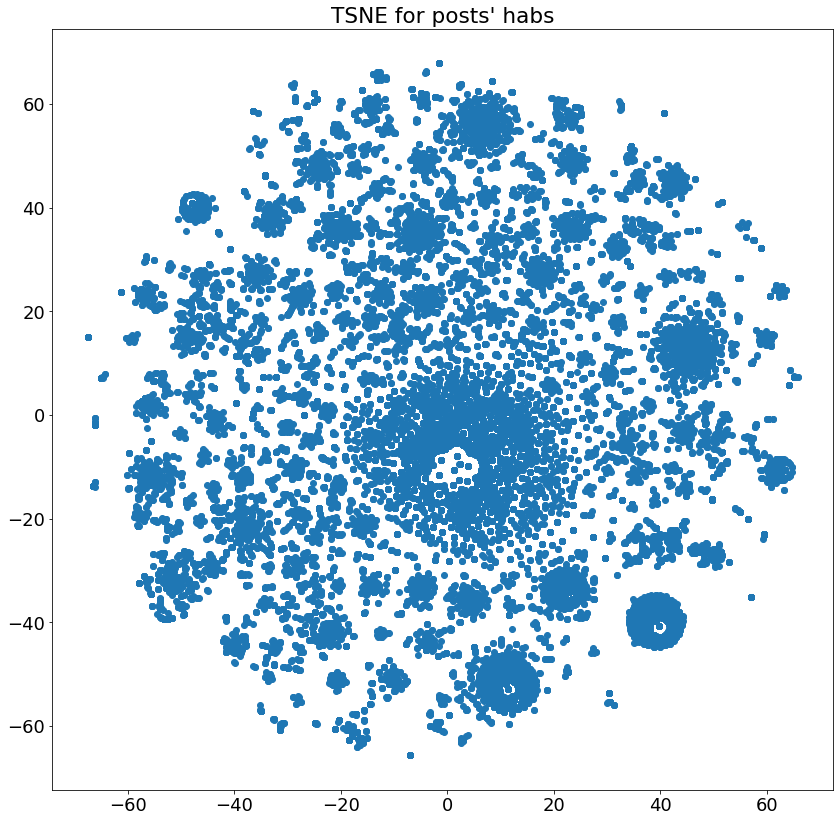

In [36]:
plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 18})
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('TSNE for posts\' habs')
plt.show()

In [38]:
import json

with open('tsne.json', 'w') as f:
    f.write(json.dumps(X_embedded.tolist(), indent=4))

In [ ]:
from sklearn.cluster import MeanShift

cluster = MeanShift(n_jobs=-1)

model = cluster.fit(X)

In [66]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
dbscan.fit(decoded_habs_list)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [87]:
print('Len of', dbscan.labels_, "is", len(dbscan.labels_))
print('Clusters count:', len(set(dbscan.labels_)))

Len of [ -1   0   1 ... 335 335  78] is 38443
Clusters count: 704


In [78]:
habs_clusters = {}
for label, habs_vec in zip(dbscan.labels_, decoded_habs_list):
    if label in habs_clusters:
        habs_clusters[label].append(habs_vec)
    else:
        habs_clusters[label] = [habs_vec]
for key in habs_clusters:
    print(key, ' => ', len(habs_clusters[label]))

-1  =>  239
0  =>  239
1  =>  239
2  =>  239
3  =>  239
4  =>  239
5  =>  239
6  =>  239
7  =>  239
8  =>  239
9  =>  239
10  =>  239
11  =>  239
12  =>  239
13  =>  239
14  =>  239
15  =>  239
16  =>  239
17  =>  239
18  =>  239
19  =>  239
20  =>  239
21  =>  239
22  =>  239
23  =>  239
24  =>  239
25  =>  239
26  =>  239
27  =>  239
28  =>  239
29  =>  239
30  =>  239
31  =>  239
32  =>  239
33  =>  239
34  =>  239
35  =>  239
36  =>  239
37  =>  239
38  =>  239
39  =>  239
40  =>  239
41  =>  239
42  =>  239
43  =>  239
44  =>  239
45  =>  239
46  =>  239
47  =>  239
48  =>  239
49  =>  239
50  =>  239
51  =>  239
52  =>  239
53  =>  239
54  =>  239
55  =>  239
56  =>  239
57  =>  239
58  =>  239
59  =>  239
60  =>  239
61  =>  239
62  =>  239
63  =>  239
64  =>  239
65  =>  239
66  =>  239
67  =>  239
68  =>  239
69  =>  239
70  =>  239
71  =>  239
72  =>  239
73  =>  239
74  =>  239
75  =>  239
76  =>  239
77  =>  239
78  =>  239
79  =>  239
80  =>  239
81  =>  239
82  =>  239
83

In [89]:
encoded_habs_clusters = {
    key: [transformer.encode_vec(vec) for vec in habs_clusters[key]]
    for key in habs_clusters
}
encoded_habs_clusters[0]

[['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика'],
 ['Научная фантастика']]

In [93]:
encoded_habs_clusters[23]

[['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение'],
 ['Машинное обучение']]

In [96]:
encoded_habs_clusters[600]

[['Бизнес-модели', 'Управление e-commerce'],
 ['Бизнес-модели', 'Управление e-commerce'],
 ['Бизнес-модели', 'Управление e-commerce'],
 ['Бизнес-модели', 'Управление e-commerce'],
 ['Бизнес-модели', 'Управление e-commerce']]

In [106]:
import json 
with open('notebooks/clusters.json', 'w') as f:
    f.write(json.dumps({int(key): encoded_habs_clusters[key] for key in encoded_habs_clusters}, indent=4))

In [102]:
!ls -lah notebooks

итого 7,6M
drwxrwxr-x  3 leadness leadness 4,0K сен 24 01:27 .
drwxrwxr-x 11 leadness leadness 4,0K сен 24 01:26 ..
-rw-rw-r--  1 leadness leadness 702K сен  7 12:33 BigramMarkov.ipynb
-rw-rw-r--  1 leadness leadness 5,6M сен 24 01:28 clusters.json
-rw-rw-r--  1 leadness leadness  52K авг 26 22:59 EncodedMarkovT9.ipynb
drwxrwxr-x  2 leadness leadness 4,0K сен  9 19:28 .ipynb_checkpoints
-rw-rw-r--  1 leadness leadness 216K сен 14 23:33 MarkovifyChainEncoder.ipynb
-rw-rw-r--  1 leadness leadness 136K июл 27 18:16 Markov.ipynb
-rw-rw-r--  1 leadness leadness  51K авг 24 21:42 MarkovWithGenerators.ipynb
-rw-rw-r--  1 leadness leadness 155K сен 17 02:18 SplitByTopic.ipynb
-rw-rw-r--  1 leadness leadness 188K авг 27 22:10 test.json
-rw-rw-r--  1 leadness leadness 405K июл 23 13:06 WikiParse.ipynb
-rw-rw-r--  1 leadness leadness  60K сен  9 19:43 WikiTexts.ipynb


In [105]:
len(encoded_habs_clusters[-1])

13582